## Project Microcalcification Classification

This dataset was constructed by scanning the images, segmenting them intocandidate objects, and using computer vision techniques to describe each candidate object. It is a popular dataset for imbalanced classification because of the severe class imbalance,specifically where 98 percent of candidate microcalcifications are not cancer and only 2 percentwere labeled as cancer by an experienced radiographer


### Mamography Dataset

The dataset is credited toKevin Woods, et al.  and the 1993 paper titledComparative Evaluation Of Pattern RecognitionTechniques For Detection Of Microcalcifications In Mammography.
The dataset involved first started with 24 mammograms with a known cancer diagnosis thatwere scanned.  The images were then pre-processed using image segmentation computer visionalgorithms to extract candidate objects from the mammogram images.  Once segmented, theobjects were then manually labeled by an experienced radiologist.  A total of 29 features wereextracted from the segmented objects thought

- Area of object (in pixels).
- Average gray level of the object.
- Gradient strength of the object’s perimeter pixels.
- Root mean square noise fluctuation in the object.
- Contrast, average gray level of the object minus the average of a two-pixel wide bordersurrounding the object.
- A low order moment based on shape descriptor.

There are two classes and the goal is to distinguish between microcalcifications and non-microcalcifications using the features for a given segmented object.

- Non-microcalcifications:  negative case, or majority class.
- Microcalcifications:  positive case, or minority class.

Models were evaluated using ROC Curvesand compared using the area under ROC Curve, or ROC AUC for short.
ROC Curves and area under ROC Curves were chosen with the intent to minimize the false-positive rate (complement of the specificity) and maximize the true-positive rate (sensitivity),the two axes of the ROC Curve.  The use of the ROC Curves also suggests the desire for aprobabilistic model from which an operator can select a probability threshold as the cut-offbetween the acceptable false positive and true positive rates.  Their results suggested alinearclassifier(seemingly a Gaussian Naive Bayes classifier) performed the best with a ROC AUC of 0.936 averaged over 100 runs. 

In [20]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score 
from sklearn.dummy import DummyClassifier
sns.set()

#### Explore dataset

In [21]:
# url =  "https://raw.githubusercontent.com/jbrownlee/Datasets/master/mammography.csv"
data = pd.read_csv('data/mammography.csv', index_col=None)
print(data.shape)
target = data.values[:, -1]
counter = Counter(target)
for k, v in counter.items():
    per = v/ target.shape[0]
    print("Class=%s, Percentage=%.3f" % (k, per))

(11183, 7)
Class='-1', Percentage=0.977
Class='1', Percentage=0.023


We can see that the dataset has six rather than the seven input variables plus one target variable.  It is possiblethat the first input variable listed in the paper (area in pixels) was removed from this versionof the dataset.  The input variables are numerical (real-valued) and the target variable is thestring with‘-1’for the majority class and‘1’for the minority class.  

I believe this is the same dataset, in —SMOTE: Synthetic Minority Over-sampling Technique, 2002 although I cannot explain the mismatch in the number of input features, e.g.  six compared to seven in the original paper.  We can also take a look at thedistribution of the six numerical input variables by creating a histogram for each. 

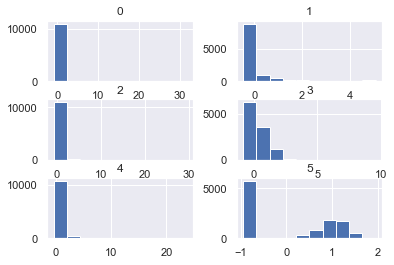

In [22]:
data.hist();

We can see that the variables have differing scales andthat most of the variables have an exponential distribution, e.g.  most cases falling into one bin,and the rest falling into a long tail.  The final variable appears to have a bimodal distribution.

 We can also color the dots of each scatter plot according to the class label.In this case, the majority class (no cancer) will be mapped to blue dots and the minority class(cancer) will be mapped to red dots.  The complete example is listed below.

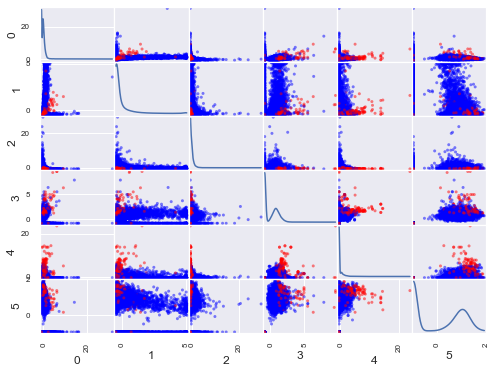

In [43]:
color_dict = {
    "'-1'": 'blue',
    "'1'" : 'red'
}
colors_map = list(color_dict[str(x)] for x in target)# pd.Series(target).map(color_dict) map color to each point
scatter_matrix(data, diagonal='kde', color=test, figsize=(8,6));

We can see that the distributions for many variables do differ for the two-classlabels, suggesting that some reasonable discrimination between the cancer and no cancer caseswill be feasible.

#### Model Test and Baseline Result

In [44]:
data

,0,1,2,3,4,5,6
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'
...,...,...,...,...,...,...,...
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,'1'
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,'1'
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,'1'
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,'1'


In [57]:
def load_dataset(full_path):
    df = pd.read_csv(full_path, index_col=0)
    X, y =df.iloc[:,:-1], df.iloc[:,-1]
    y = LabelEncoder().fit_transform(y) #0, 1 encoding
    return X, y

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=cv, n_jobs=-1, scoring = 'roc_auc')
    return scores

Finally, we can evaluate a baseline model on the dataset using this test harness.  A model that predicts a random class label in proportion to the base rate of each class will result ina ROC AUC of 0.5, the baseline in performance on this dataset.  This is a so-called no skillclassifier.  This can be achieved using the DummyClassifierclass from the scikit-learn library and setting the strategyargument to ‘stratified’.

In [58]:
X, y = load_dataset("data/mammography.csv")
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='stratified')
scores = evaluate_model(X, y, model)
print("Mean ROC AUC : %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

(11183, 5) (11183,) Counter({0: 10923, 1: 260})
Mean ROC AUC : 0.499 (0.012)
